In [30]:
from copy import deepcopy
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt


recurrent_projective True
recurrent_receptive True
gain False
readin.weight False
readin.bias False
recurrent.weight False
readout.weight False
readout.bias False

recurrent_projective False
recurrent_receptive True
gain True
readin.weight False
readin.bias False
recurrent.weight False
readout.weight False
readout.bias False

recurrent_projective True
recurrent_receptive False
gain True
readin.weight False
readin.bias False
recurrent.weight False
readout.weight False
readout.bias False
Epoch 0, Loss [0.697, 0.697, 0.697], Accuracy tensor([48., 48., 48.])
Epoch 10, Loss [0.695, 0.695, 0.694], Accuracy tensor([51., 51., 51.])
Epoch 20, Loss [0.687, 0.688, 0.687], Accuracy tensor([62., 60., 60.])
Epoch 30, Loss [0.686, 0.688, 0.687], Accuracy tensor([61., 60., 63.])
Epoch 40, Loss [0.679, 0.688, 0.687], Accuracy tensor([62., 53., 57.])
Epoch 50, Loss [0.67, 0.684, 0.681], Accuracy tensor([60., 64., 69.])
Epoch 60, Loss [0.669, 0.685, 0.682], Accuracy tensor([64., 60., 61.])
Epoch 70, Los

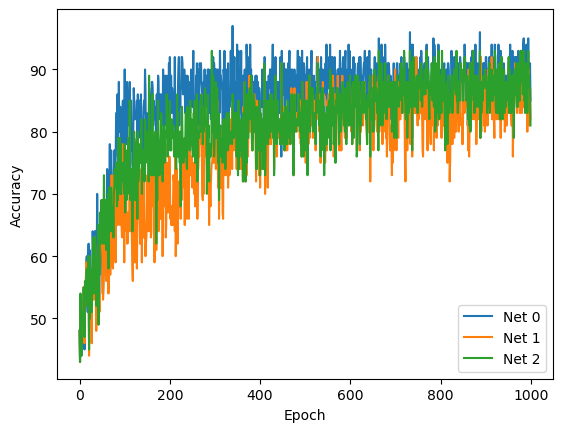

In [60]:
class GainNet(nn.Module):
    """
    dx_i/dt = -x_i + sum_j g_i * A_ij * f(x_j) + I_i
    This formulation puts the gain on the inputs directly
    or 
    dx_i/dt = -x_i + sum_j A_ij * f(g_i * x_j) + I_i
    This formulation puts the gain on the outputs
    """
    def __init__(self, input_dim, hidden_dim, output_dim, beta=0.9):
        super(GainNet, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.readin = nn.Linear(input_dim, hidden_dim)
        
        self.recurrent = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.recurrent_projective = nn.Parameter(torch.randn(hidden_dim)/hidden_dim)
        self.recurrent_receptive = nn.Parameter(torch.randn(hidden_dim)/hidden_dim)

        self.relu = nn.ReLU()
        self.gain = nn.Parameter(torch.randn(hidden_dim)/hidden_dim)
        self.readout = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

        self.beta = beta

    def forward(self, x):
        # Initialize hidden states and outputs
        batch_size = x.size(0)
        sequence_size = x.size(1)
        activations = torch.zeros((batch_size, self.hidden_dim))
        out = torch.zeros((batch_size, self.output_dim))

        # Recurrent loop
        for step in range(sequence_size):
            input_in = self.readin(x[:, step]) # This is the I term
            hidden = self.relu(activations) # This is the f(x) terms (using formulation 1)
            # This is the sum_j A_ij * f(x_j) term
            recurrent_in = self.recurrent(hidden) +  hidden @ (self.recurrent_projective.unsqueeze(1) @ self.recurrent_receptive.unsqueeze(0)).T
            delta_activations = -activations*self.beta + input_in + recurrent_in * torch.exp(self.gain)
            activations = activations + delta_activations
            out[x[:, step, -1]==1] += self.readout(hidden)[x[:, step, -1]==1]

        return self.softmax(out)

def generate_data(v, sigma, T, B):
    v = v / torch.norm(v)  # Make sure v is normalized
    s = (torch.rand(B)>0.5) * 2.0 - 1.0

    # Generate noise
    noise = torch.randn(B, T, len(v)) * sigma

    X = noise + s.unsqueeze(1).unsqueeze(2) * v.unsqueeze(0).unsqueeze(1)
    s_empirical = torch.mean(X @ v, dim=1)

    labels = (s_empirical > 0).long()  # Generate labels

    X = X / torch.norm(X, dim=2, keepdim=True) / 2.0

    cue = torch.zeros(B, T)
    cue[:, T//2:] = 1.0

    X = torch.cat((X, cue.unsqueeze(2)), dim=2)

    return X, s_empirical, labels 

# Hyperparameters
B = 100 # Batch size
D = 1 # Input dimensions
N = 50 # Number of recurrent neurons
T = 20 # Time steps per trial

# Generate random input vector
v = torch.normal(0, 1, (D,))
v = v / torch.norm(v)

sigma = 3.0  # Noise amplitude
learning_rate = 0.001
num_epochs = 1000

# Create network
net0 = GainNet(D+1, N, 2)
net1 = deepcopy(net0)
net2 = deepcopy(net0)

nets = [net0, net1, net2]
no_grad = ["readin.weight", "readin.bias", "recurrent.weight", "readout.weight", "readout.bias"]
names = ["gain", "recurrent_projective", "recurrent_receptive"]
for name, net in zip(names, nets):
    for prm_name, prm in net.named_parameters():
        if prm_name in names:
            prm.requires_grad = True
        if prm_name in no_grad: 
            prm.requires_grad = False
        if prm_name == name:
            prm.requires_grad = False

print('')
for prm_name, prm in net0.named_parameters():
    print(prm_name, prm.requires_grad)
print('')
for prm_name, prm in net1.named_parameters():
    print(prm_name, prm.requires_grad)
print('')
for prm_name, prm in net2.named_parameters():
    print(prm_name, prm.requires_grad)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set optimizers but filter parameters by requires grad
optimizers = [torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=learning_rate) for net in nets]

# Save accuracy
num_nets = len(nets)
save_accuracy = torch.zeros((num_nets, num_epochs))

# Training loop
for epoch in range(num_epochs):
    X, s, labels = generate_data(v, sigma, T, B)

    for opt in optimizers:
        opt.zero_grad()

    outputs = [net(X) for net in nets]
    loss = [criterion(output, labels) for output in outputs]  # Use only the last time step for loss
    for l in loss:
        l.backward()
    for opt in optimizers:
        opt.step()

    choices = [torch.argmax(output, dim=1) for output in outputs]
    accuracy = torch.tensor([torch.sum(choice == labels).item() / B * 100 for choice in choices])
    save_accuracy[:, epoch] = accuracy

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {[np.round(l.item()*1000)/1000 for l in loss]}, Accuracy {accuracy}")

# Plot accuracy
fig = plt.figure()
for i in range(num_nets):
    plt.plot(save_accuracy[i], label=f"Net {i}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()